In [1]:
import logging

import matplotlib.pyplot as plt
import numpy as np
import pairinteraction.real as pi
from pairinteraction import perturbative, ureg
from pairinteraction.visualization.colormaps import alphamagma

logging.basicConfig(format="%(name)s %(levelname)s: %(message)s", level=logging.WARNING)

if pi.Database.get_global_database() is None:
    pi.Database.initialize_global_database(download_missing=True)

logger = logging.getLogger("pairinteraction.perturbative.create_system")
logger.setLevel(logging.DEBUG)

# C6 coefficient for MQDT states

In [2]:
ket = pi.KetAtom("Yb174_mqdt", nu=80.0, s=0.0, j=1.0, f=1, m=0)

# You can either use get_c6 without a distacence vector
# this will create a basis with ~ 2000 nearby (coupled) states
c6_no_d = perturbative.get_c6((ket, ket), unit="GHz mum^6")
print(f"C6({ket}) without distance_vector: {c6_no_d} GHz mum^6")

# Or you can use get_c6 with a distance vector
# this will estimate how many states to take into account to get "accurate" results
# in second order perturbation theory
distance_vector = ureg.Quantity([0.0, 0.0, 5], "mum")
c6 = perturbative.get_c6((ket, ket), distance_vector, unit="GHz mum^6")
print(f"C6({ket}) with {distance_vector=}: {c6} GHz mum^6")

pairinteraction.perturbative.create_system DEBUG: The basis of the pair system estimated from the interaction energy is very small (9 kets). This might lead to misleading results, thus we will increase delta energy, to at least include 2000 number of states.
pairinteraction.perturbative.create_system DEBUG: The pair basis for the perturbative calculations consists of 2530 kets.


C6(|Yb174:S=0.4,nu=80.0,L=1.0,J=1,0⟩) without distance_vector: 3136.635629420141 GHz mum^6


pairinteraction.perturbative.create_system DEBUG: The pair basis for the perturbative calculations consists of 45628 kets.
pairinteraction.perturbative.create_system WARNING: The basis of the pair system is very large (45628 kets). This might lead to long calculation times. Consider using a smaller basis by adjusting the min_population_admixture.


C6(|Yb174:S=0.4,nu=80.0,L=1.0,J=1,0⟩) with distance_vector=<Quantity([0. 0. 5.], 'micrometer')>: 3088.7343736077746 GHz mum^6


For comparison, we also calculate the pair potential by exact diagonalization.

In [3]:
basis_atom = pi.BasisAtom(ket.species, nu=(76.0, 84.0), s=(0, 0.5), j=(0, 3.0))
system_atom = pi.SystemAtom(basis_atom)
print(f"Basis atom #kets: {basis_atom.number_of_kets}")

pair_energy = 2 * system_atom.get_corresponding_energy(ket, unit="GHz")
basis_pair = pi.BasisPair(
    [system_atom, system_atom],
    energy=(pair_energy - 3.5, pair_energy + 3.5),
    energy_unit="GHz",
)
print(f"Basis pair #kets: {basis_pair.number_of_kets}")

distances = np.linspace(4, 9, 20)
systems = [pi.SystemPair(basis_pair).set_distance(d, unit="mum") for d in distances]
pi.diagonalize(systems, diagonalizer="lapacke_evr", float_type="float32")

eigenenergies = [system.get_eigenenergies(unit="GHz") - pair_energy for system in systems]
overlaps = [system.get_eigenbasis().get_overlaps([ket, ket]) for system in systems]

Basis atom #kets: 136
Basis pair #kets: 1173


As can be seen in the plot below, the C6 coefficent describes the pair potential curve of our state of interest very well.

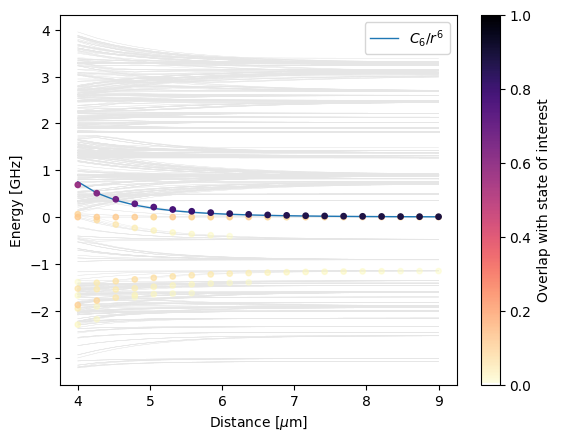

In [4]:
fig, ax = plt.subplots()

ax.set_xlabel(r"Distance [$\mu$m]")
ax.set_ylabel("Energy [GHz]")

try:
    ax.plot(distances, np.array(eigenenergies), c="0.9", lw=0.25, zorder=-10)
except ValueError:  # inhomogeneous shape -> no simple line plot possible
    for x, es in zip(distances, eigenenergies):
        ax.plot([x] * len(es), es, c="0.9", ls="None", marker=".", zorder=-10)

x_repeated = np.hstack([val * np.ones_like(es) for val, es in zip(distances, eigenenergies)])
energies_flattend = np.hstack(eigenenergies)
overlaps_flattend = np.hstack(overlaps)
sorter = np.argsort(overlaps_flattend)

scat = ax.scatter(
    x_repeated[sorter],
    energies_flattend[sorter],
    c=overlaps_flattend[sorter],
    s=15,
    vmin=0,
    vmax=1,
    cmap=alphamagma,
)

fig.colorbar(scat, ax=ax, label="Overlap with state of interest")

ax.plot(distances, c6 / distances**6, c="C0", lw=1, label=r"$C_6/r^6$", zorder=-10)
ax.legend()

plt.show()